In [1]:
import jax
import jax.numpy as jnp
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions
tfb = tfp.bijectors

from jaxlie import SO3
from so3dm.distributions.isotropic_gaussian import IsotropicGaussianSO3
from so3dm.plotting import visualize_so3_probabilities, visualize_so3_density

import tensorflow_datasets as tfds
import tensorflow as tf

from flax.metrics import tensorboard
import haiku as hk
import optax

from tqdm import tqdm

2023-05-10 08:59:41.792860: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/packages/AI/tensorflow_23.02-2.10.0-py3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.neighbors import radius_neighbors_graph
import jraph
from jraph._src import utils as jraph_utils
import networkx as nx
import jax.tree_util as tree
from typing import Any, Callable, Dict, List, Optional, Tuple

In [3]:
import os
os.environ["XLA_FLAGS"]="--xla_gpu_force_compilation_parallelism=1"

In [4]:
jnp.linalg.inv(jnp.eye(3))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [5]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_72139/1757885639.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
import pickle
from halotools_ia.correlation_functions import  ed_3d, ee_3d,gi_plus_3d, gi_plus_projected, ii_minus_3d, ii_minus_projected, ii_plus_3d, ii_plus_projected, ed_projected, ed_3d_one_two_halo_decomp


In [7]:
tng = pickle.load(  open('/jet/home/yjagvara/SO3Diffusion_Tidal/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl', "rb" ) )
tng = tng[tng['dm_mass']>0]
tng = tng[log10(tng['dm_mass']*10**10)>9]
tng = tng[log10(tng['mass']*10**10)>9]
#tng = tng[tng['central_bool']==1.0]
 

In [8]:
tng

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,251.0163116455078,0.0,27477.935546875,23325.619140625,1.0,38878.03515625,849.0914306640625,26326.99609375,18306.93359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.8295962810516357,0.51895672082901,0.5298088788986206
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,-0.9840750455762398,-0.006859759853817557,0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,-0.15940066178344028,0.4762611707976621,-0.8647350612837673,-0.25285616517066956,-0.542943046543665,-0.8007974784346137,-0.0015899779481896464,-0.8274600252025045,0.5615223759228073,0.9675025711735737,-0.14325765215776112,-0.20836511193280413,340.0297044488053,304.0921077455601,251.82406385313607,-0.43189844489097595,-0.6954925306839556,-0.5742419895334245,-0.7976

In [9]:
group_key='GroupID'
pos_key=['gal_pos_x', 'gal_pos_y', 'gal_pos_z']
scalar_key = ['mass']
catalog = tng

# It takes a minute but we precompute all the graphs and data
# Identify the individual groups and pre-extract the relevant data

group_ids = catalog[group_key].astype(jnp.int32)
gids, idx = jnp.unique(group_ids, return_index=True) # gids are the unique group ids, in other words All the host halo IDS uniquely  extracted     idx = The indices of the first occurrences of the unique values in the original array. i.e index of the central galaxy
Position = jnp.array(catalog[pos_key].to_pandas())
Scalars = jnp.array(catalog[scalar_key].to_pandas())
#np.array(catalog[pos_key]).reshape((-1, 3))
#Position =  np.array(catalog[pos_key]).view(np.float64).reshape((-1, 3)).astype(np.float32)

In [10]:
graph_radius = 1 #Mpc
graphs_list = []
node_features_list = []

In [11]:

for gid in gids:
    
    g = np.where(group_ids == gid)[0]
    Positions_for_group = Position[g]
    Features_for_group = Scalars[g]
 



    # Compute adjacency matrix for each entry
    graph = radius_neighbors_graph(Positions_for_group, graph_radius, mode='connectivity',
                               include_self=False)
    graphs_list.append(graph)
    node_features_list.append(Features_for_group)
    

In [12]:
idx = 100 # Group ID number (Halo ID number)
single_graph =  graphs_list[idx].tocoo()
node_features = node_features_list[idx]

In [13]:
single_graph.nnz

132

In [14]:
GP =  jraph_utils.sparse_matrix_to_graphs_tuple(single_graph.row.astype(jnp.int64), single_graph.col.astype(jnp.int64), single_graph.data.astype(jnp.int64), jnp.asarray([single_graph.shape[0]]) )


In [15]:
GP = GP._replace(nodes=node_features)

In [16]:
GP.n_edge

array([132])

In [17]:
GP_padded = jraph.pad_with_graphs(GP, n_node=15, n_edge=300, n_graph=2)

In [18]:
GP_padded.senders

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12

In [19]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw_networkx(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

In [20]:
print(GP.nodes)

[[16.9458    ]
 [ 5.7596083 ]
 [ 9.42481   ]
 [ 5.508431  ]
 [ 2.6174016 ]
 [ 0.2598723 ]
 [ 0.49025574]
 [ 0.5248196 ]
 [ 0.2764002 ]
 [ 0.29288748]
 [ 0.18927753]
 [ 0.1580491 ]]


In [33]:
GP

GraphsTuple(nodes=Array([[16.9458    ],
       [ 5.7596083 ],
       [ 9.42481   ],
       [ 5.508431  ],
       [ 2.6174016 ],
       [ 0.2598723 ],
       [ 0.49025574],
       [ 0.5248196 ],
       [ 0.2764002 ],
       [ 0.29288748],
       [ 0.18927753],
       [ 0.1580491 ]], dtype=float32), edges=None, receivers=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11,  0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,
        1,  2,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  5,  6,  7,
        8,  9, 10, 11,  0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11,  0,  1,
        2,  3,  4,  5,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  8,
        9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11,  0,  1,  2,
        3,  4,  5,  6,  7,  8, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), senders=array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
        1,

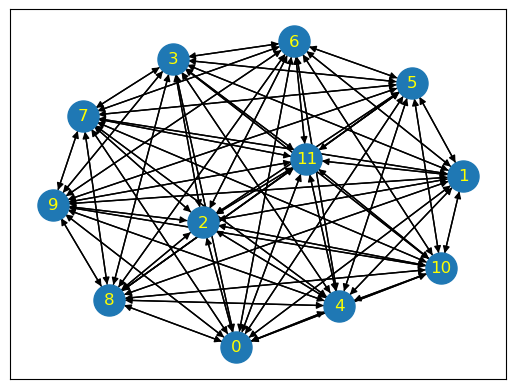

In [21]:
draw_jraph_graph_structure(GP)

In [22]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

In [23]:
updated_GP = apply_simplified_gcn(GP)

In [24]:
class MLP(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))

    mlp = hk.Sequential(layers)
    return mlp(x)

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(features=[8, 4])(x)

In [25]:
def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

In [26]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = True) -> Callable:
  """Returns a method that applies a Graph Convolution layer.

  Graph Convolutional layer as in https://arxiv.org/abs/1609.02907,
  NOTE: This implementation does not add an activation after aggregation.
  If you are stacking layers, you may want to add an activation between
  each layer.
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_nodes_fn: function used to aggregates the sender nodes.
    add_self_edges: whether to add self edges to nodes in the graph as in the
      paper definition of GCN. Defaults to False.
    symmetric_normalization: whether to use symmetric normalization. Defaults to
      True.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      # In principle, a `GraphsTuple` should partition by n_edge, but in
      # this case it is not required since a GCN is agnostic to whether
      # the `GraphsTuple` is a batch of graphs or a single large graph.
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN

In [27]:
gcn_layer = GraphConvolution(
    update_node_fn=lambda n: MLP(features=[8, 4])(n),
    aggregate_nodes_fn=jax.ops.segment_sum,
    add_self_edges=True,
    symmetric_normalization=True
)

In [28]:
graph = GP
network = hk.without_apply_rng(hk.transform(gcn_layer))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.25692433,  0.5843294 , -0.89831734, -1.1385084 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385084 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843294 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843295 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843295 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843295 , -0.8983172 , -1.1385086 ],
       [-0.25692433,  0.5843295 , -0.8983172 , -1.1385086 ]],      dtype=float32)

In [29]:
def gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a graph neural network with 3 GCN layers.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(8)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=lambda n: jax.nn.relu(hk.Linear(4)(n)),
      add_self_edges=True)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2))
  graph = gn(graph)
  return graph

In [30]:
graph = GP
network = hk.without_apply_rng(hk.transform(gcn))
params = network.init(jax.random.PRNGKey(42), graph)
out_graph = network.apply(params, graph)
out_graph.nodes

Array([[-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712],
       [-0.3135708,  0.1036712]], dtype=float32)

In [31]:
def optimize_club(network: hk.Transformed, num_steps: int) -> jnp.ndarray:
  """Solves the karate club problem by optimizing the assignments of students."""
  zacharys_karate_club = get_zacharys_karate_club()
  labels = get_ground_truth_assignments_for_zacharys_karate_club()
  params = network.init(jax.random.PRNGKey(42), zacharys_karate_club)

  @jax.jit
  def predict(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.argmax(decoded_graph.nodes, axis=1)

  @jax.jit
  def prediction_loss(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    # We interpret the decoded nodes as a pair of logits for each node.
    log_prob = jax.nn.log_softmax(decoded_graph.nodes)
    # The only two assignments we know a-priori are those of Mr. Hi (Node 0)
    # and John A (Node 33).
    return -(log_prob[0, 0] + log_prob[33, 1])

  opt_init, opt_update = optax.adam(1e-2)
  opt_state = opt_init(params)

  @jax.jit
  def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(prediction_loss)(params)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

  @jax.jit
  def accuracy(params: hk.Params) -> jnp.ndarray:
    decoded_graph = network.apply(params, zacharys_karate_club)
    return jnp.mean(jnp.argmax(decoded_graph.nodes, axis=1) == labels)

  for step in range(num_steps):
    print(f"step {step} accuracy {accuracy(params).item():.2f}")
    params, opt_state = update(params, opt_state)

  return predict(params)

In [32]:
network = hk.without_apply_rng(hk.transform(gcn_definition))
result = optimize_club(network, num_steps=15)

NameError: name 'gcn_definition' is not defined

In [ ]:
GP.n_node

In [ ]:
GP_batched = jraph.batch( [GP,GP])

In [ ]:
batch_size = 128

dset = tf.data.Dataset.from_tensor_slices(explicitly_batched_graph)

dset = dset.repeat()
dset = dset.shuffle(buffer_size=10000)
dset = dset.batch(batch_size)
dset = dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dset = dset.as_numpy_iterator()
_ = next(dset)

In [ ]:
GP_batched = jraph

In [ ]:
def graph_input_fn(catalog,
                   vector_features=(), scalar_features=(),
                   vector_labels=(), scalar_labels=(),
                   pos_key=['gal_pos_x', 'gal_pos_y', 'gal_pos_z'],
                   group_key='GroupID', batch_size=128,
                   noise_size=32,
                   graph_radius=1000., shuffle=False, repeat=False,
                   prefetch=100, poolsize=12, balance_key='group_mass_scaled',
                   rotate=False):
    """
    Python generator function that will create batches of graphs from
    input catalog.
    """
    
    features = vector_features + scalar_features
    labels = vector_labels + scalar_labels

    # It takes a minute but we precompute all the graphs and data
    # Identify the individual groups and pre-extract the relevant data
    group_ids = catalog[group_key]
    gids, idx = np.unique(group_ids, return_index=True)
 
    # Extracts columns of interest into memory first
    Xsp = np.array(catalog[pos_key]).view(np.float64).reshape((-1, 3)).astype(np.float32)
    X = np.array(catalog[features]).view(np.float64).reshape((-1, len(features))).astype(np.float32)
    Y = np.array(catalog[labels]).view(np.float64).reshape((-1, len(labels))).astype(np.float32)
    #nan_mask = (~np.isnan(Xsp).any(axis=1)) & (~np.isnan(X).any(axis=1)) & (~np.isnan(Y).any(axis=1))
    Xsp = Xsp[ (~np.isnan(Xsp).any(axis=1))]
    X = X[(~np.isnan(X).any(axis=1))]
    Y = Y[(~np.isnan(Y).any(axis=1))]
 
    n_batches = len(gids) // batch_size
    last_batch = len(gids) % batch_size

    n_features = len(vector_features) // 3
    n_labels = len(vector_labels) // 3

 
        cache = p.map(_process_graph, [(gid, group_ids, Xsp, X, Y, n_features, n_labels, graph_radius) for gid in gids])
 

In [ ]:
gid, group_ids, Xsp, X, Y, n_features, n_labels, graph_radius = args
g = np.where(group_ids == gid)[0]
xsp = Xsp[g]
x = X[g]
y = Y[g]
# Compute adjacency matrix for each entry
graph = radius_neighbors_graph(xsp, graph_radius, mode='connectivity',
                               include_self=False)


In [ ]:
        cache = p.map(_process_graph, [(gid, group_ids, Xsp, X, Y, n_features, n_labels, graph_radius) for gid in gids])


In [ ]:

def _process_graph(args):
    """
    Function that preprocesses the dataset for fast training
    """
    gid, group_ids, Xsp, X, Y, n_features, n_labels, graph_radius = args
    g = np.where(group_ids == gid)[0]
    xsp = Xsp[g]
    x = X[g]
    y = Y[g]
    # Compute adjacency matrix for each entry
    graph = radius_neighbors_graph(xsp, graph_radius, mode='connectivity',
                                   include_self=False)

    return (xsp, x, y, graph)

In [ ]:
single_graph = jraph.GraphsTuple(
  n_node=np.asarray([3]), n_edge=np.asarray([2]),
  nodes=np.ones((3, 4)), edges=np.ones((2, 5)),
  globals=np.ones((1, 6)),
  senders=np.array([0, 1]), receivers=np.array([2, 2]))


nested_graph = jraph.GraphsTuple(
  n_node=np.asarray([3]), n_edge=np.asarray([2]),
  nodes={"a": np.ones((3, 4))}, edges={"b": np.ones((2, 5))},
  globals={"c": np.ones((1, 6))},
  senders=np.array([0, 1]), receivers=np.array([2, 2]))


implicitly_batched_graph = jraph.GraphsTuple(
  n_node=np.asarray([3, 1]), n_edge=np.asarray([2, 1]),
  nodes=np.ones((4, 4)), edges=np.ones((3, 5)),
  globals=np.ones((2, 6)),
  senders=np.array([0, 1, 3]), receivers=np.array([2, 2, 3]))

implicitly_batched_graph = jraph.batch(
  [single_graph, implicitly_batched_graph])



In [ ]:
 explicitly_batched_graph = jraph.GraphsTuple(
      n_node=np.asarray([[3], [1]]), n_edge=np.asarray([[2], [1]]),
      nodes=np.ones((2, 3, 4)), edges=np.ones((2, 2, 5)),
      globals=np.ones((2, 1, 6)),
      senders=np.array([[0, 1], [0, -1]]),
      receivers=np.array([[2, 2], [0, -1]]))

In [ ]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node):
      nx_graph.add_node(n)
  else:
     for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw_networkx(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

draw_jraph_graph_structure(explicitly_batched_graph)

In [ ]:
explicitly_batched_graph.nodes




In [ ]:
batch_size = 10

dset = tf.data.Dataset.from_tensor_slices(explicitly_batched_graph)

dset = dset.repeat()
dset = dset.shuffle(buffer_size=10000)
dset = dset.batch(batch_size)
dset = dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dset = dset.as_numpy_iterator()
_ = next(dset)

In [ ]:
test = next(dset)

In [ ]:
test.n_node

In [ ]:
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([64,64,64], activation=jax.nn.leaky_relu)(feats)
  
  #Linear(2) #two features feature.shape
  
  return net


def gcn_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  """Defines a GCN for the karate club task.
  Args:
    graph: GraphsTuple the network processes.

  Returns:
    output graph with updated node values.
  """
  gn = GraphConvolution(
      update_node_fn=node_update_fn,
      add_self_edges=False)
  graph = gn(graph)

  gn = GraphConvolution(
      update_node_fn=hk.Linear(2)) # output dim is 2 because we have 2 scalars.
  graph = gn(graph)
  return graph

In [ ]:
def f_e(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([feat.shape[-1]*2+2, feat.shape[-1] ], activation=jax.nn.silu)(feats)
  return net

def f_inf(m_ij: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP( [32,1], activation=jax.nn.sigmoid)(feats)
  return net

def f_h(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([feat.shape[-1]*2+2, feat.shape[-1] ], activation=jax.nn.silu)(feats)
  return net


def f_x(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.nets.MLP([feat.shape[-1]*2+2, 1 ], activation=jax.nn.silu)(feats)
  return net

In [ ]:
# GAT implementation adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L442.
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:
 


  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
 
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)
    
    distances = nodes[:,:3][senders] - nodes[:,:3][receivers]
     
    
    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)

    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

In [ ]:
def attention_logit_fn(sender_attr: jnp.ndarray, receiver_attr: jnp.ndarray,
                       edges: jnp.ndarray) -> jnp.ndarray:
  del edges
  x = jnp.concatenate((sender_attr, receiver_attr), axis=1)
  return hk.Linear(1)(x)


gat_layer = GAT(
    attention_query_fn=lambda n: hk.Linear(8)
    (n),  # Applies W to the node features
    attention_logit_fn=attention_logit_fn,
    node_update_fn=None,
    add_self_edges=True,
)

In [ ]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphConvolution(update_node_fn: Callable,
                     aggregate_nodes_fn: Callable = jax.ops.segment_sum,
                     add_self_edges: bool = False,
                     symmetric_normalization: bool = False) -> Callable:
 
  def _ApplyGCN(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, _, receivers, senders, _, _, _ = graph

    # First pass nodes through the node updater.
    nodes = update_node_fn(nodes)
    # Equivalent to jnp.sum(n_node), but jittable
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
 
      conv_receivers, conv_senders = add_self_edges_fn(receivers, senders,
                                                       total_num_nodes)
    else:
      conv_senders = senders
      conv_receivers = receivers

    # pylint: disable=g-long-lambda
    if symmetric_normalization:
      # Calculate the normalization values.
      count_edges = lambda x: jax.ops.segment_sum(
          jnp.ones_like(conv_senders), x, total_num_nodes)
      sender_degree = count_edges(conv_senders)
      receiver_degree = count_edges(conv_receivers)

      # Pre normalize by sqrt sender degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x: x * jax.lax.rsqrt(jnp.maximum(sender_degree, 1.0))[:, None],
          nodes,
      )
      # Aggregate the pre-normalized nodes.
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
      # Post normalize by sqrt receiver degree.
      # Avoid dividing by 0 by taking maximum of (degree, 1).
      nodes = tree.tree_map(
          lambda x:
          (x * jax.lax.rsqrt(jnp.maximum(receiver_degree, 1.0))[:, None]),
          nodes,
      )
    else:
      nodes = tree.tree_map(
          lambda x: aggregate_nodes_fn(x[conv_senders], conv_receivers,
                                       total_num_nodes), nodes)
    # pylint: enable=g-long-lambda
    return graph._replace(nodes=nodes)

  return _ApplyGCN